# Tetrakis Lattice: Black Hole Waves & Frequency Analysis

This notebook demonstrates discrete wave propagation, black hole defects, and frequency (FFT) analysis on a 3D tetrakis-square lattice.

**Features:**
- Modular project root setup and code import
- 3D tetrakis lattice with user-definable size and layers
- Black hole defect (event horizon) and advanced visualization
- Discrete wave simulation (finite-difference)
- Heatmaps and animation of wave propagation by floor
- Local and global FFT analysis (single node, dominant freq map, mean spectrum)
- All code is research-grade and fully reproducible

*Project: [tetrakis-sim](https://github.com/MikeLawrenchuk/tetrakis-sim)  
Author: Mike Lawrenchuk*

---


In [1]:
import os, sys

def find_and_set_project_root(project_name="tetrakis-sim"):
    cur = os.getcwd()
    while os.path.basename(cur) != project_name:
        parent = os.path.dirname(cur)
        if parent == cur:
            raise RuntimeError(f"Project root '{project_name}' not found!")
        cur = parent
    os.chdir(cur)
    if cur not in sys.path:
        sys.path.insert(0, cur)
    print("Project root set to:", cur)

find_and_set_project_root()

import matplotlib.pyplot as plt
import numpy as np
from tetrakis_sim.lattice import build_sheet
from tetrakis_sim.defects import apply_blackhole_defect, find_event_horizon
from tetrakis_sim.physics import run_wave_sim, run_fft
from tetrakis_sim.plot import plot_floor_with_circle, plot_fft


Project root set to: /Users/MWL/Desktop/tetrakis-sim


In [2]:
# Parameters
size = 9
layers = 5
G = build_sheet(size=size, dim=3, layers=layers)

bh_center = (size//2, size//2, layers//2)
bh_radius = 2.5

removed_nodes = apply_blackhole_defect(G, bh_center, bh_radius)
horizon_nodes = find_event_horizon(G, removed_nodes, bh_radius, bh_center)

print(f"Lattice with black hole: {len(G.nodes)} nodes remain.")


Lattice with black hole: 1296 nodes remain.


In [3]:
import numpy as np

# Step 1: Find all (r, c, q) present on all layers, as before
all_layers = sorted(set(n[2] for n in G))
base_nodes = set((r, c, q) for (r, c, z, q) in G.nodes if z == all_layers[0])
for z_val in all_layers[1:]:
    nodes_at_z = set((r, c, q) for (r, c, z, q) in G.nodes if z == z_val)
    base_nodes &= nodes_at_z

# Step 2: Find the "most central" node by minimizing distance from lattice center
center_rc = (size // 2, size // 2)
def centrality_score(rcq):
    r, c, q = rcq
    return np.hypot(r - center_rc[0], c - center_rc[1])

most_central = min(base_nodes, key=centrality_score)
chosen_r, chosen_c, chosen_q = most_central
print(f"Most central node present in all layers: {most_central}")

# Step 3: Kick that node in every layer
initial_data = {}
for z_val in all_layers:
    node = (chosen_r, chosen_c, z_val, chosen_q)
    initial_data[node] = 1.0  # or your chosen amplitude

print("Kick node across all layers:", [(chosen_r, chosen_c, z_val, chosen_q) for z_val in all_layers])


Most central node present in all layers: (6, 2, 'A')
Kick node across all layers: [(6, 2, 0, 'A'), (6, 2, 1, 'A'), (6, 2, 2, 'A'), (6, 2, 3, 'A'), (6, 2, 4, 'A')]


In [4]:
steps = 50
history = run_wave_sim(G, steps=steps, initial_data=initial_data)
print(f"Wave simulation complete. Time steps: {len(history)}")


Wave simulation complete. Time steps: 51


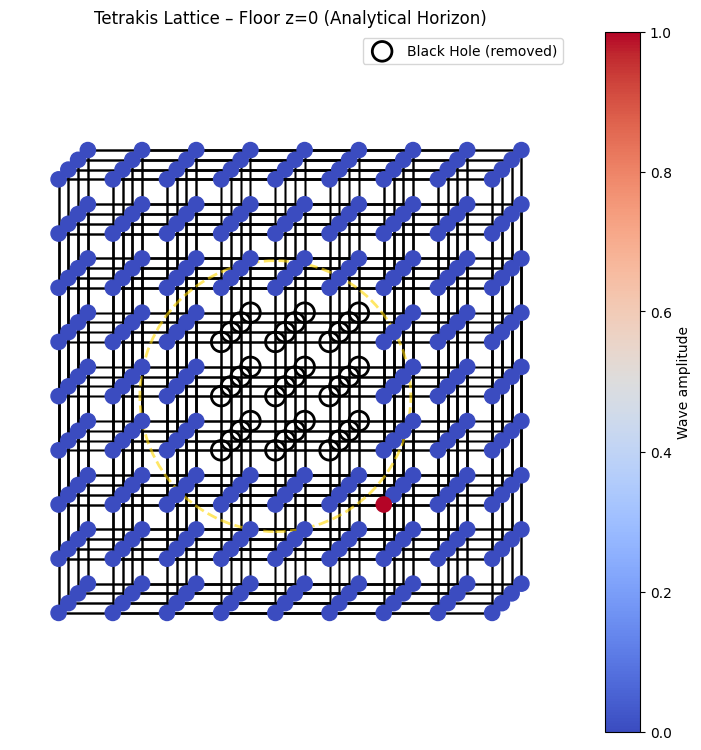

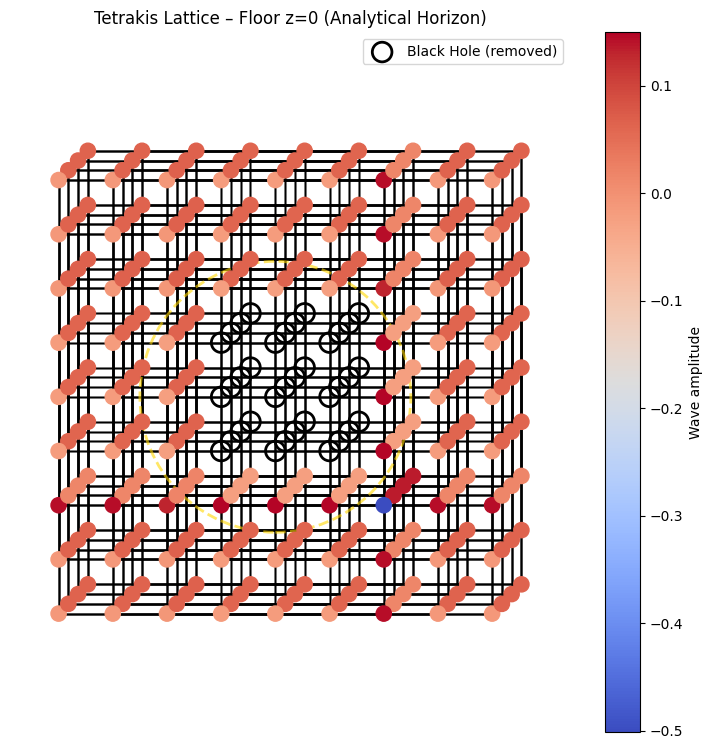

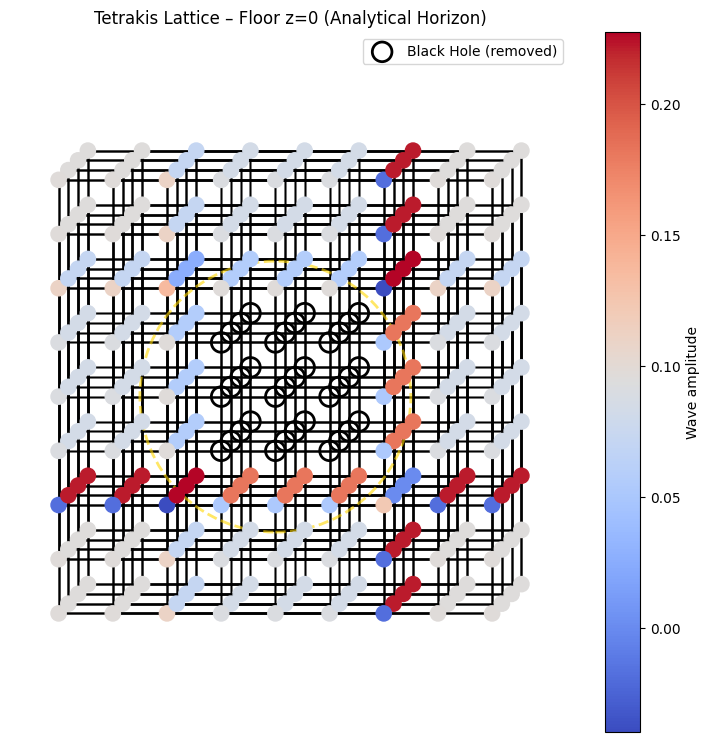

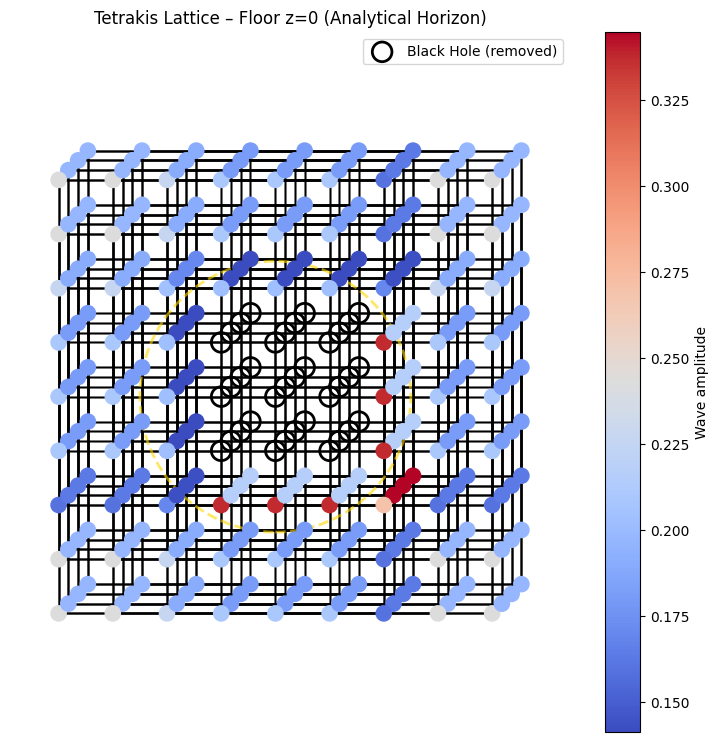

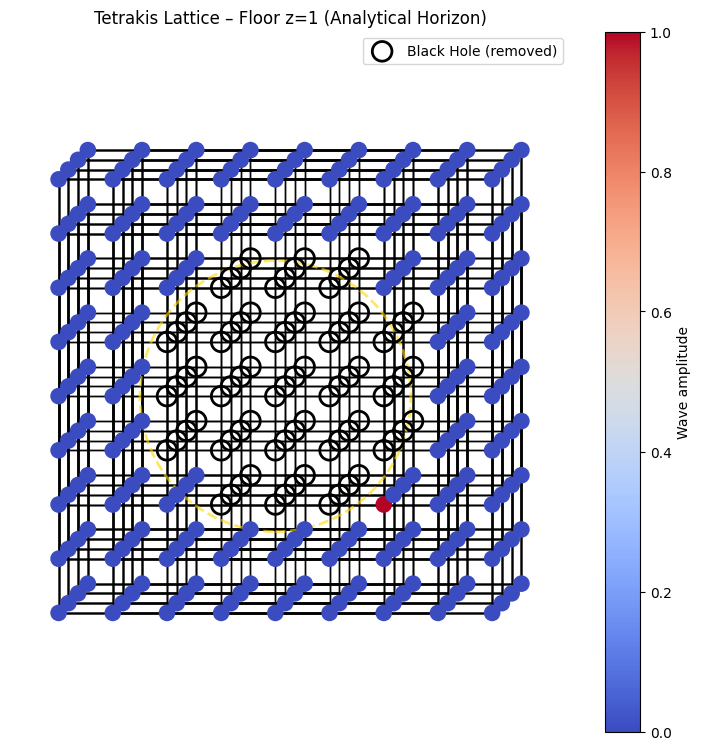

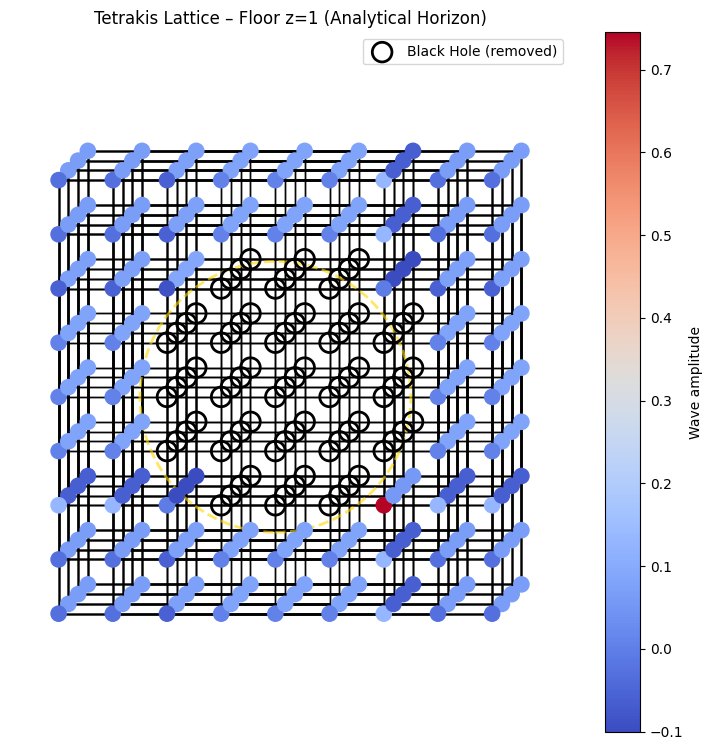

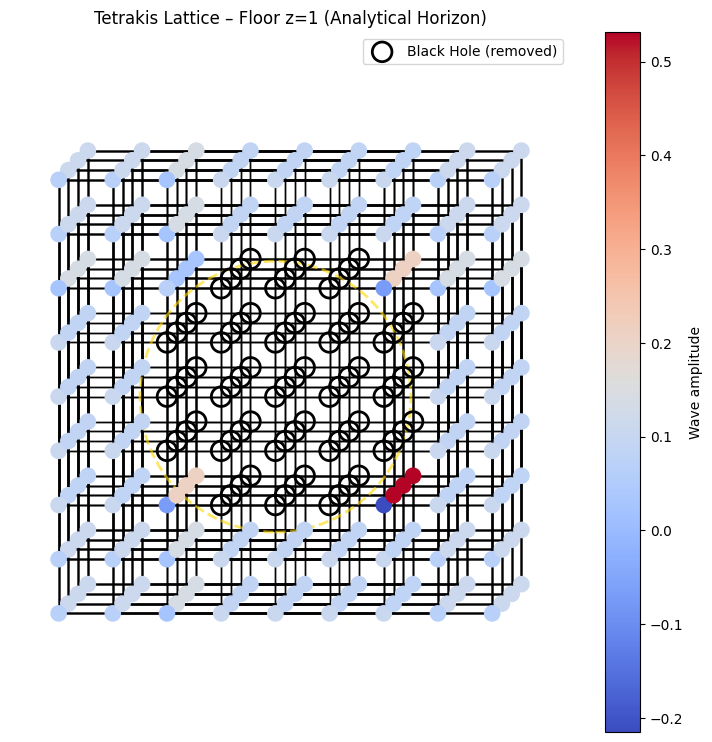

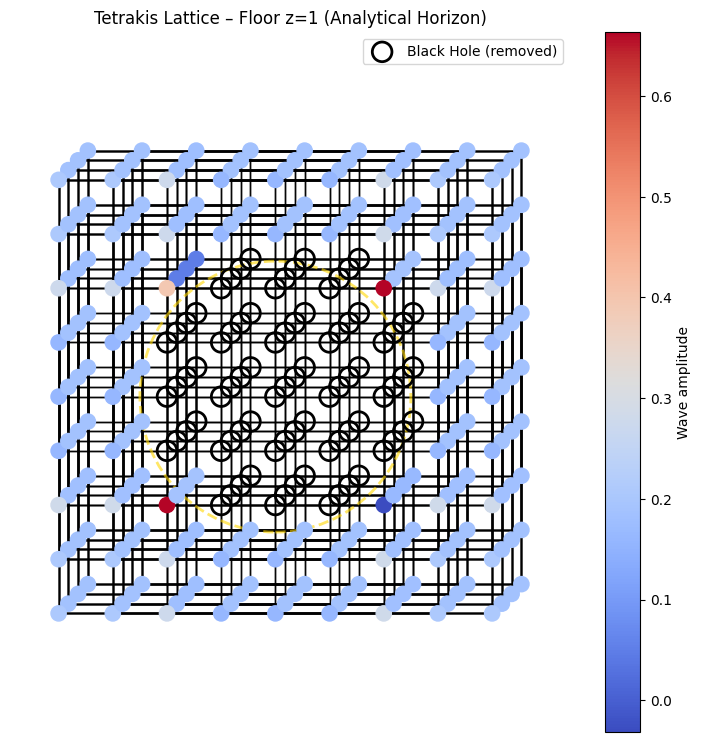

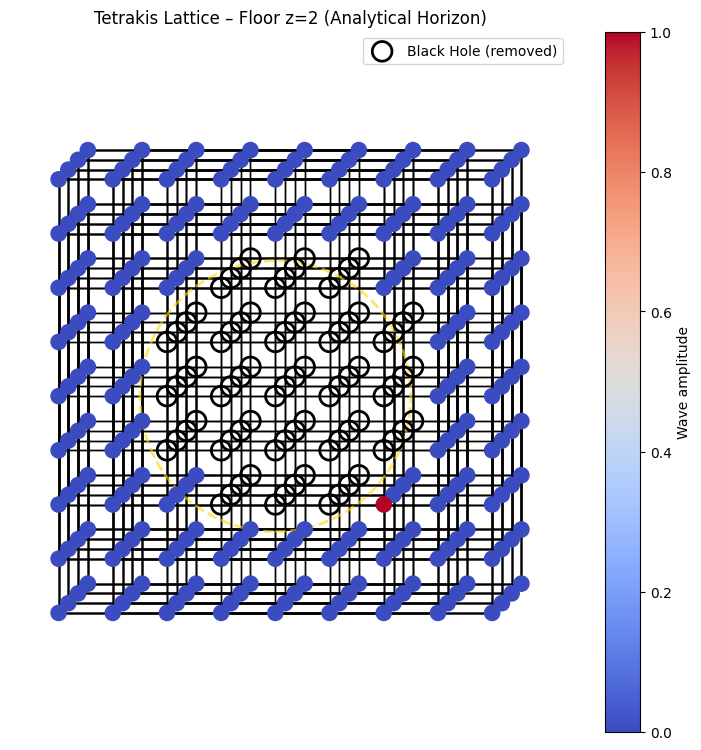

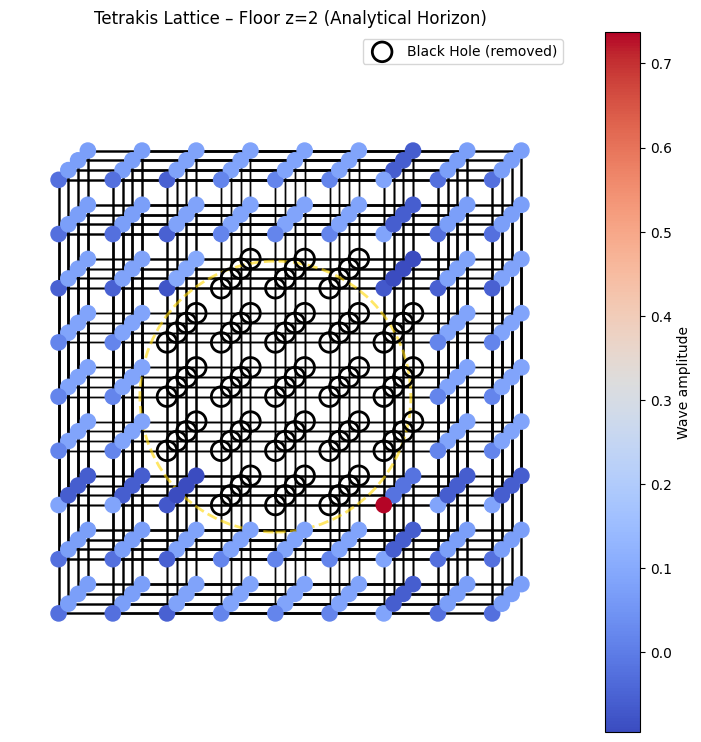

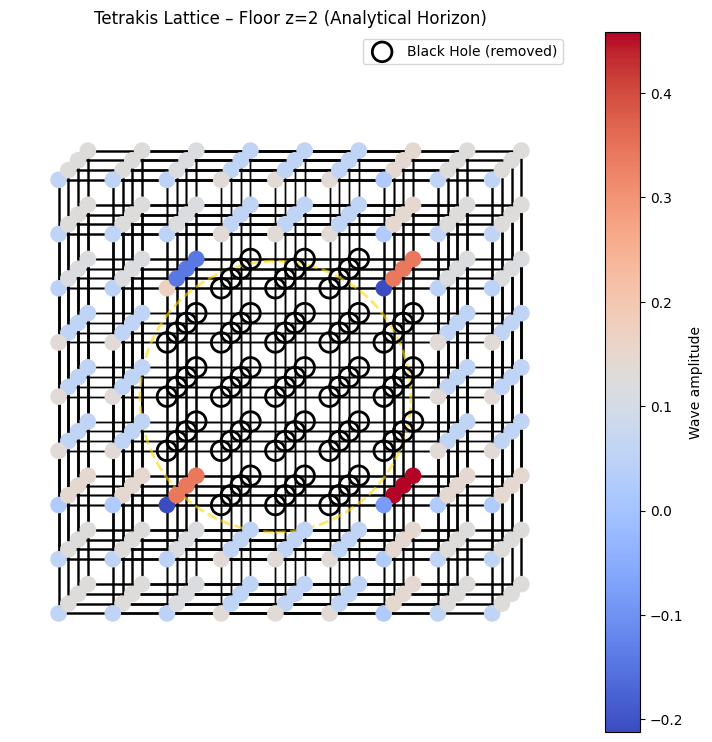

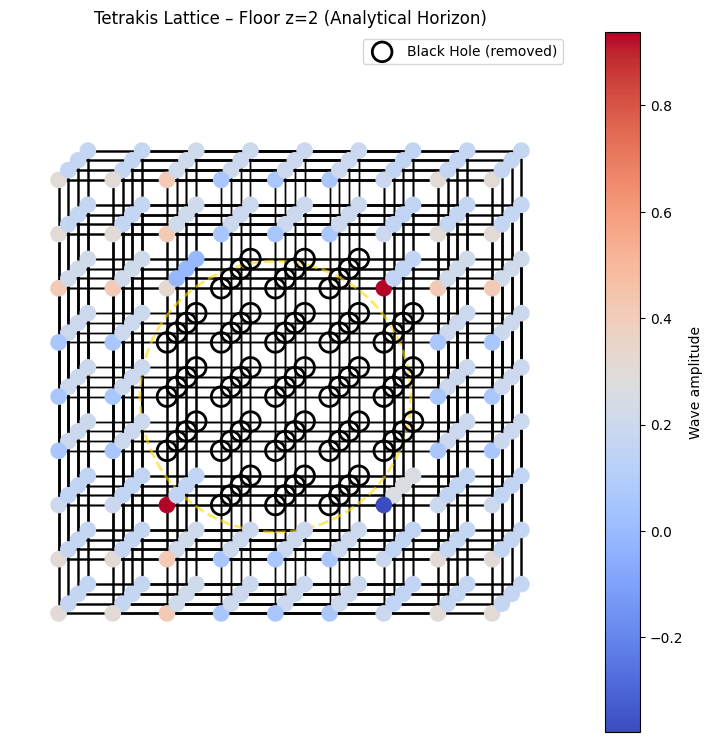

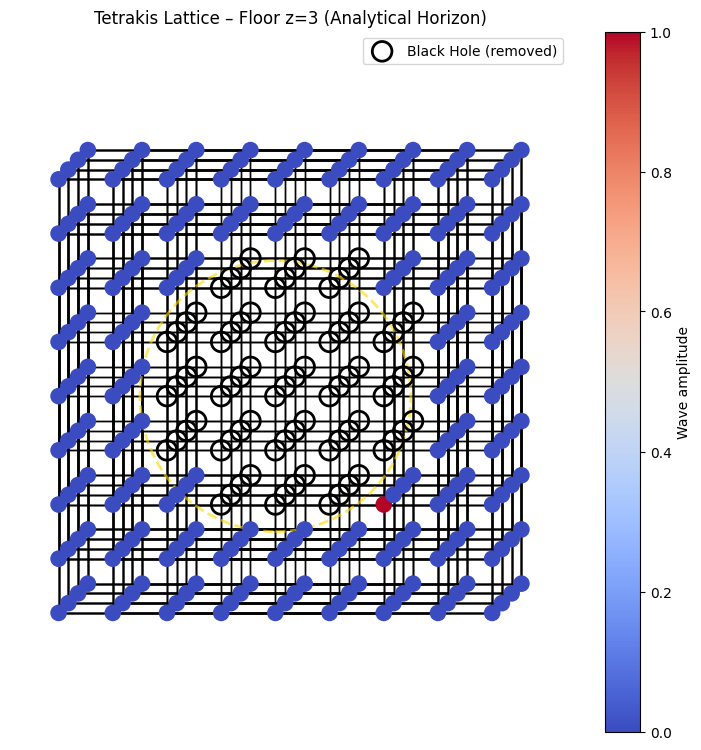

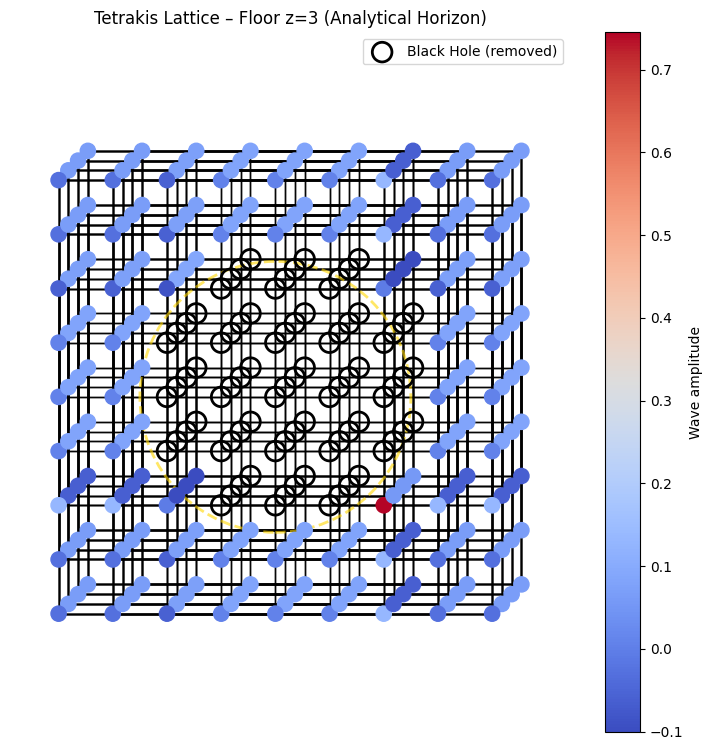

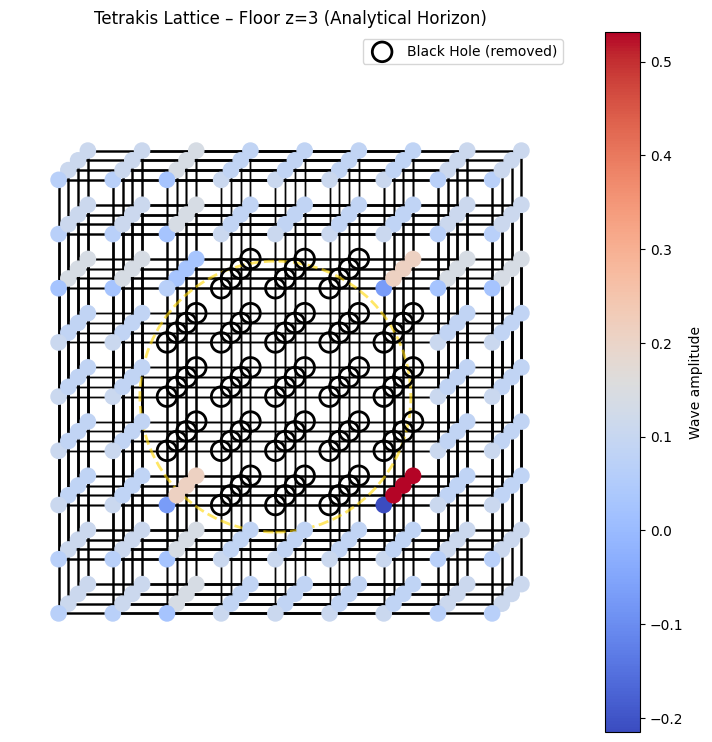

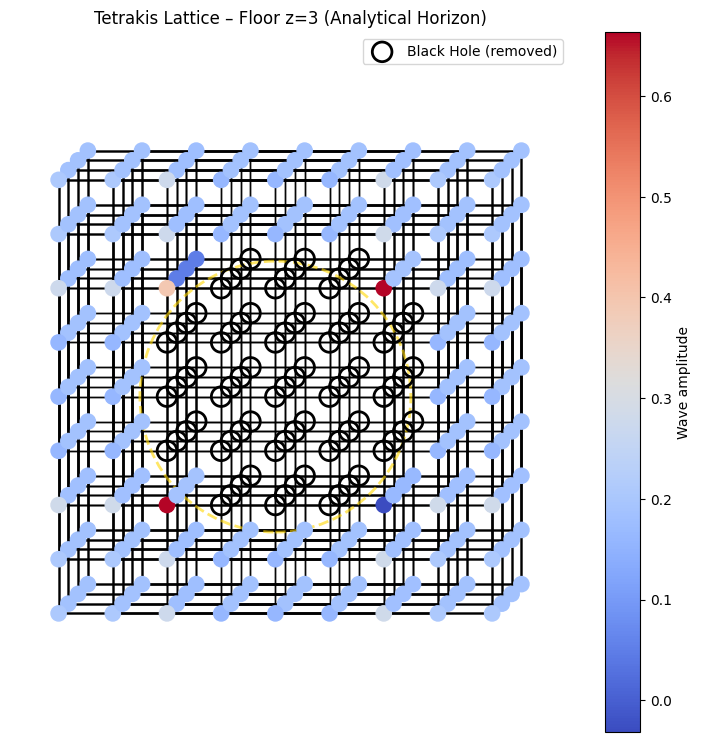

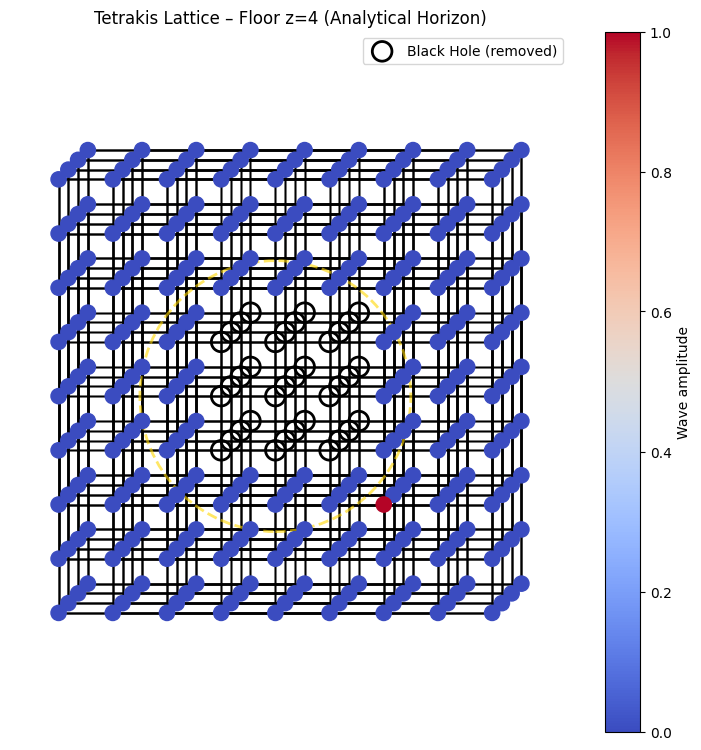

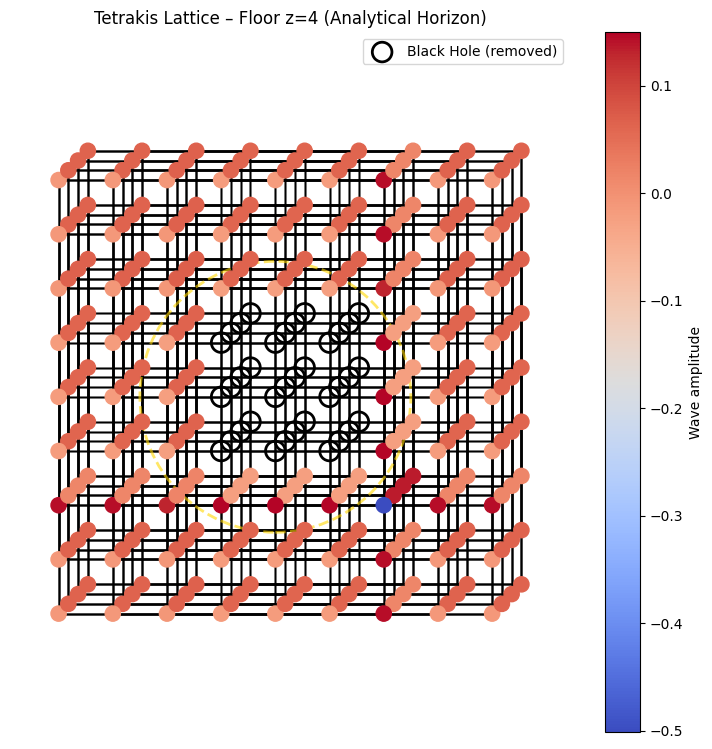

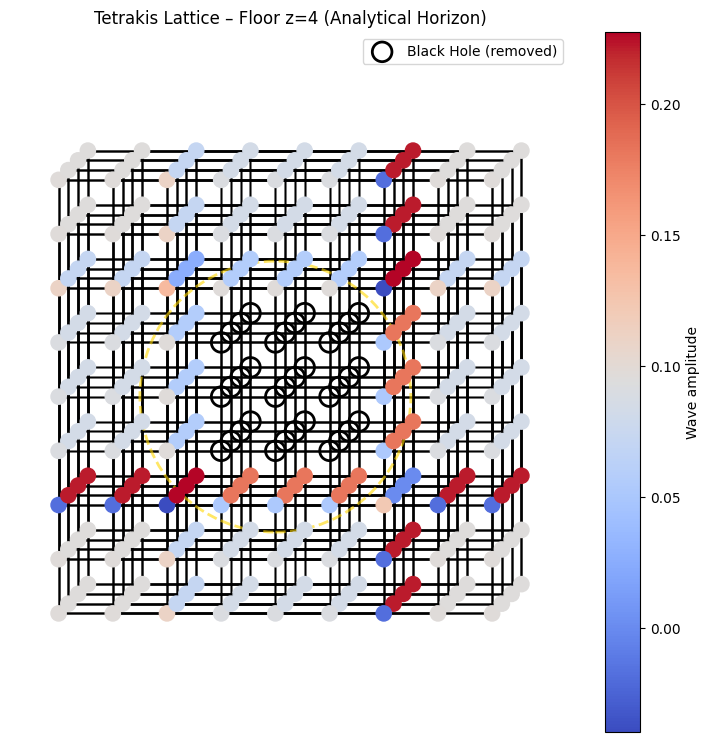

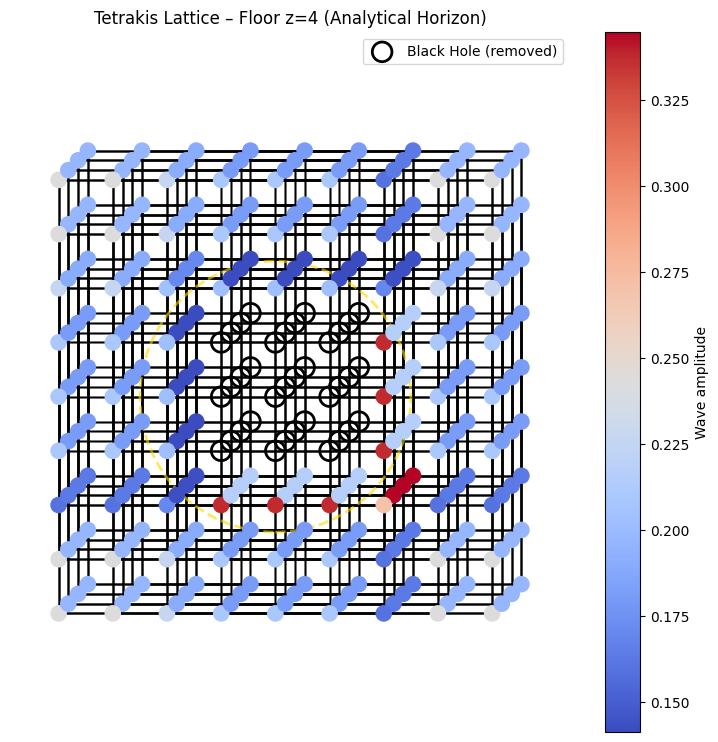

In [5]:
for z in range(layers):
    for t in [0, 10, 25, 49]:
        data = history[t]
        plot_floor_with_circle(
            G, z,
            center=bh_center,
            radius=bh_radius,
            highlight_nodes=removed_nodes,
            boundary_nodes=horizon_nodes,
            data=data,
            show=True
        )


Animating 288 nodes on layer z=4
First 5 nodes in this layer: [(0, 0, 4, 'A'), (0, 0, 4, 'B'), (0, 0, 4, 'C'), (0, 0, 4, 'D'), (0, 1, 4, 'A')]


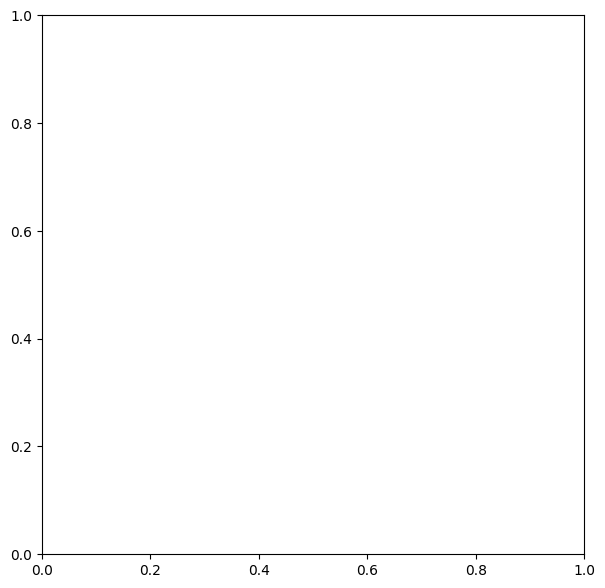

In [6]:
import matplotlib.animation as animation

# Check for nodes before animating
nodes_on_layer = [n for n in G if n[2] == z]
print(f"Animating {len(nodes_on_layer)} nodes on layer z={z}")
print("First 5 nodes in this layer:", nodes_on_layer[:5])

if len(nodes_on_layer) == 0:
    print(f"No nodes found for z={z}. Try a different z value or check your lattice/defect setup.")
else:
    def node_pos(node):
        r, c, z, q = node
        offset = 0.18 * "ABCD".index(q)
        return (r + offset, c + offset)
    pos = {n: node_pos(n) for n in nodes_on_layer}
    xs, ys = zip(*[pos[n] for n in nodes_on_layer])

    fig, ax = plt.subplots(figsize=(7,7))

    def animate(t):
        ax.clear()
        data = history[t]
        vals = [data.get(n, 0.0) for n in nodes_on_layer]
        print(f"Time {t}, first 10 vals:", vals[:10])  # Debug print here
        sc = ax.scatter(xs, ys, c=vals, cmap='coolwarm', s=120)
        ax.set_title(f"Wave Propagation – Floor z={z}, Time step {t}")
        ax.axis('equal')
        plt.colorbar(sc, ax=ax, label="Wave amplitude")

    anim = animation.FuncAnimation(fig, animate, frames=len(history), interval=100)
    plt.show()
    # Optionally save: anim.save('wave_animation.gif', writer='pillow')


FFT for node: (6, 2, 2, 'A')


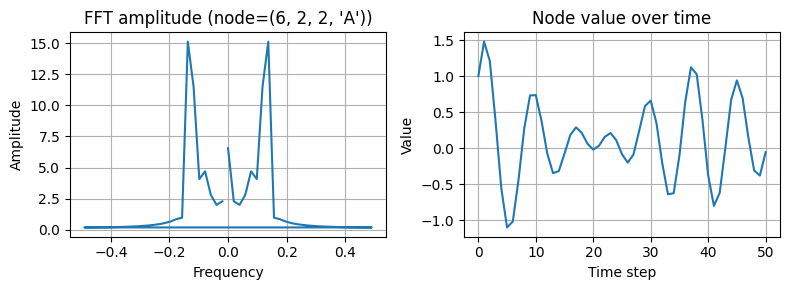

In [7]:
# Cell 7: FFT for the node that was kicked

import numpy as np

# (Repeat these lines to ensure the most central node is found, safe even if already run)
all_layers = sorted(set(n[2] for n in G))
base_nodes = set((r, c, q) for (r, c, z, q) in G.nodes if z == all_layers[0])
for z_val in all_layers[1:]:
    nodes_at_z = set((r, c, q) for (r, c, z, q) in G.nodes if z == z_val)
    base_nodes &= nodes_at_z

center_rc = (size // 2, size // 2)
def centrality_score(rcq):
    r, c, q = rcq
    return np.hypot(r - center_rc[0], c - center_rc[1])

most_central = min(base_nodes, key=centrality_score)
chosen_r, chosen_c, chosen_q = most_central

# Choose which layer to analyze (same as your animated/plotted layer)
z = layers // 2  # or any layer
node = (chosen_r, chosen_c, z, chosen_q)
print(f"FFT for node: {node}")

# FFT analysis and plot (node as positional argument)
freq, spectrum, values = run_fft(history, node)
plot_fft(freq, spectrum, node=node, values=values)


FFT for node: (6, 2, 2, 'A')


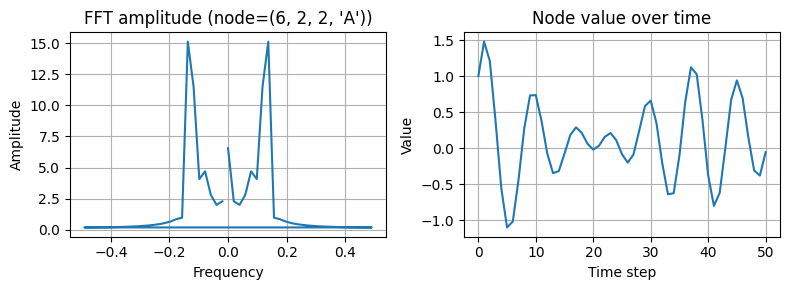

In [8]:
# FFT for the "most central" node you kicked in the layer you're visualizing
z = layers // 2  # Or any floor you want
node = (chosen_r, chosen_c, z, chosen_q)
print(f"FFT for node: {node}")

freq, spectrum, values = run_fft(history, node=node)
plot_fft(freq, spectrum, node=node, values=values)


Calculating dominant frequencies for each node in floor z= 2


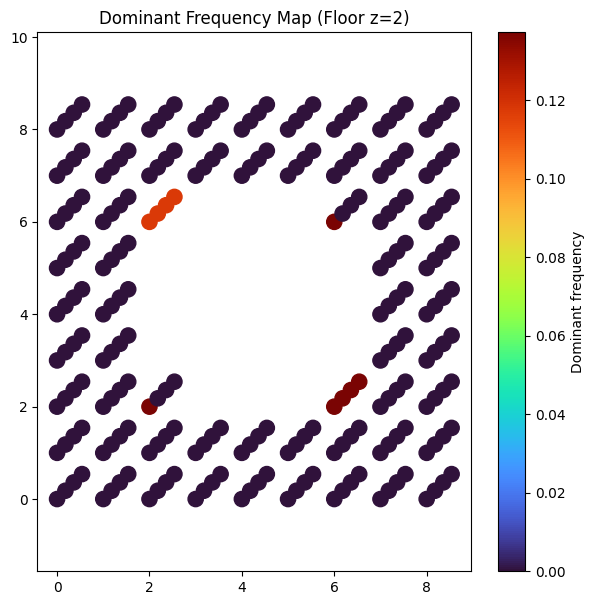

In [9]:
import numpy as np

z = layers // 2  # Or any layer you want to analyze
nodes_on_layer = [n for n in G if n[2] == z]
dominant_freqs = []

print("Calculating dominant frequencies for each node in floor z=", z)
for n in nodes_on_layer:
    freq, spectrum, values = run_fft(history, node=n)
    dom_idx = np.argmax(spectrum)
    dom_freq = freq[dom_idx]
    dominant_freqs.append(dom_freq)

# Plot the dominant frequency as a heatmap
xs, ys = zip(*[(n[0] + 0.18 * "ABCD".index(n[3]), n[1] + 0.18 * "ABCD".index(n[3])) for n in nodes_on_layer])
plt.figure(figsize=(7,7))
plt.scatter(xs, ys, c=dominant_freqs, cmap='turbo', s=120)
plt.colorbar(label="Dominant frequency")
plt.title(f"Dominant Frequency Map (Floor z={z})")
plt.axis('equal')
plt.show()


Calculating mean FFT spectrum for all nodes in floor z= 2


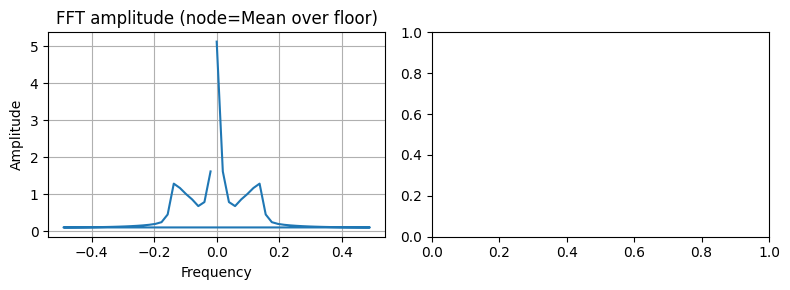

In [10]:
z = layers // 2  # Or any layer you want to analyze
nodes_on_layer = [n for n in G if n[2] == z]
spectra = []

print("Calculating mean FFT spectrum for all nodes in floor z=", z)
for n in nodes_on_layer:
    freq, spectrum, values = run_fft(history, node=n)
    spectra.append(spectrum)

mean_spectrum = np.mean(spectra, axis=0)
plot_fft(freq, mean_spectrum, node="Mean over floor", values=None)
